### Metrics and Signatures for US MTS-LSTM with M4SE loss function

Models: 
- MTS-LSTM Era5 forcing, HydroMT statics (model 1A), trained on US catchments, new loss function (M4SE)
- MTS-LSTM Nldas-2 forcing, HydroMT statics (model 2A), trained on US catchments, new loss function (M4SE)

Results
- Load MTS-LSTM model results
- Load observed streamflow
- Load forcing precipitation timeseries

Metrics:
- Load/Calculate peak metrics
- Load metrics and combine with peak metrics

Signatures:
- Load/Calcualte signatures

Comparison:
- Table with mean metrics and sigantures per model, per catchment
- Corellation between signatures based on observed streamflow and modeled streamflow

### Imports etc

In [6]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

from pandas.plotting import autocorrelation_plot, scatter_matrix

import os
import pickle
from collections import defaultdict
from typing import List, Dict, Tuple
from tqdm.notebook import tqdm
from pathlib import Path

from scipy.stats import pearsonr

from neuralhydrology.evaluation.signatures import calculate_signatures, get_available_signatures
from neuralhydrology.evaluation.metrics import calculate_metrics

from peak_magnitude import mean_peak_magnitude

In [7]:
forcing_dir = 'data/time_series/'
mts_dir = ['data/results/new_loss_US/01_era5_hydromt', 'data/results/new_loss_US/02_nldas2_camels']

frequencies = ['1D', '1H']
models = ['US_mts_era5', 'US_mts_nldas']

start_date = pd.to_datetime('2008-10-01 00:00')
end_date = pd.to_datetime('2018-09-30 23:00')

### Load data
1. HRU
2. precipitation
3. model results (simulated Q timeseries): DICT[catchtm][freq]['xr']

In [9]:
# 516 CAMELS US catchments with hourly Qobs available
with open('data/516_basins.txt', 'r') as f:
    catchments = [line.rstrip() for line in f]
    f.close()
    
# 1. Load HRU associated with each catchment
huc_df = pd.read_csv('data/camels_attributes/camels_name.txt', header=0, dtype={'gauge_id': str, 'huc_02': str}, sep=';')
huc_df.index = huc_df.gauge_id
huc_df = huc_df.drop(columns=['gauge_id', 'gauge_name'])
huc_df = huc_df.loc[huc_df.index.isin(catchments)]
huc_df.index = huc_df.index.rename('catchment')

# 2. Load precipitation (required for calculation of runoff ratio and stream elasticity)
forcing_ds_era5 = xr.open_dataset(forcing_dir + 'era5_US_all.nc')
forcing_ds_era5 = forcing_ds_era5.drop_vars('spatial_ref')
precip_era5 = forcing_ds_era5.precip
precip_era5 = precip_era5.rename({'date': 'datetime'})

precip_nldas2 = xr.open_dataset(forcing_dir + 'usgs-streamflow-nldas_hourly.nc').total_precipitation
precip_nldas2 = precip_nldas2.rename({'date': 'datetime'})

huc_catchments = {}
for huc in huc_df.huc_02.unique():
    catchment_list = huc_df.loc[huc_df['huc_02'] == '01'].index.tolist()



### MTS results

In [15]:
# DICT[catchtm][freq]['xr']
mts_era5_results = pickle.load(open(mts_dir[0] + '/test_results.p', 'rb'))
mts_nldas2_results = pickle.load(open(mts_dir[1] + '/test_results.p', 'rb'))
# mts_era5_results['01022500']['1D']['xr']

<xarray.Dataset>
Dimensions:    (date: 3652, time_step: 1)
Coordinates:
  * date       (date) datetime64[ns] 2008-10-01 2008-10-02 ... 2018-09-30
  * time_step  (time_step) int32 0
Data variables:
    qobs_obs   (date, time_step) float64 0.4453 0.3583 0.4165 ... 0.023 0.01912
    qobs_sim   (date, time_step) float64 0.1655 0.2785 ... 0.07816 0.04618

### MTS metrics and signatures

#### load or calculate peak magnitude metrics (abs and rel error)

In [16]:
repeat = False

if not os.path.isfile('data/results/new_loss_US/peak_metrics.p') or repeat:
    results_dicts = [mts_era5_results, mts_nldas2_results]
    peak_metrics_dict = defaultdict(lambda: defaultdict(dict))
    
    for j, model in enumerate(models):
        results = results_dicts[j]
        metrics_df_hourly = pd.DataFrame()
        metrics_df_daily = pd.DataFrame()

        for freq in frequencies:
            print(f'Calculating metrics for model {model}, based on {freq} results. \
                  Takes long, especially for hourly results.')
            if freq =='1D':
                metrics_df = metrics_df_daily
            if freq == '1H':
                metrics_df = metrics_df_hourly

            for i, catchment in enumerate(catchments):
                if i % 50 == 0:
                    print(i)
                    
                # get streamflow results for catchment
                ds = results[catchment][freq]['xr']

                # resample timestep
                if freq == '1H':
                    ds['time_step'] = pd.to_timedelta(ds.time_step.values, unit='hours')
                    ds = ds.isel(time_step=slice(-24, None)).stack(datetime=['date', 'time_step'])
                    ds['datetime'] = ds.coords['date'] + ds.coords['time_step']
                elif freq == '1D':
                    ds = ds.isel(time_step = -1)
                    ds = ds.drop('time_step')
                    ds = ds.rename({'date': 'datetime'})


                if j == 0:
                    var_obs = 'qobs_obs'
                    var_sim = 'qobs_sim'
                elif j ==1:
                    var_obs = 'qobs_mm_per_hour_obs'
                    var_sim = 'qobs_mm_per_hour_sim'

                # get observed streamflow
                qobs = ds[var_obs] * (24 if freq == '1D' else 1) # convert mm/h to mm/d

                # get simulated streamflow
                qsim = ds[var_sim] * (24 if freq == '1D' else 1)

                # clip predictions to 0
                qsim = xr.where(qsim < 0, 0, qsim)


                # Calculate peak metrics
                values = mean_peak_magnitude(qobs, qsim, resolution=freq)
                df_temp = pd.DataFrame(data=values, 
                                       columns=['abs_error', 'rel_error', 'peaks', 'sim<obs', 'sim>obs'],
                                       index=[catchment])
                metrics_df = metrics_df.append(other=df_temp)

            peak_metrics_dict[model][freq] = metrics_df
      
    # save nested dict to local drive
    pickle.dump({k: dict(v) for k, v in peak_metrics_dict.items()}, Path('data/results/new_loss_US/peak_metrics.p').open('wb'))
else:
    # load from local drive
    print(f'Loading peak metrics for all models from drive.')
    peak_metrics_dict = pickle.load(Path('data/results/new_loss_US/peak_metrics.p').open('rb'))

peak_metrics_dict['US_mts_era5']['1D']

Loading peak metrics for all models from drive.


,abs_error,rel_error,peaks,sim<obs,sim>obs
01022500,4.067557,0.250782,16,9,7
01031500,7.037716,0.387134,17,13,4
01047000,8.400914,0.354322,15,14,1
01052500,5.308831,0.324782,13,8,5
01054200,22.329641,0.493842,17,14,3
...,...,...,...,...,...
14309500,11.103978,0.325478,13,10,3
14316700,7.037735,0.241108,17,13,4
14325000,12.945887,0.321314,16,15,1
14362250,5.433168,1.911945,9,1,8


#### load all other metrics, combine with peak magnitude metrics, create multiindex df
- combine with HUC
- combine with cluster (from clustering on catchment charactersitics)

In [19]:
#  results dataframe metrics
results_df_m = pd.DataFrame()
name = ['era5', 'nldas2']


for i, model in enumerate(models):
    # load metrics
    mts_metrics_d = pickle.load(Path(mts_dir[i] + '/metrics_df_daily.pkl').open('rb'))
    mts_metrics_h = pickle.load(Path(mts_dir[i] + '/metrics_df_hourly.pkl').open('rb'))
    peak_metrics_d = peak_metrics_dict[model]['1D']
    peak_metrics_h = peak_metrics_dict[model]['1H']

    mts_metrics_d.index.rename('catchment')
    mts_metrics_h.index.rename('catchment')
    peak_metrics_d.index.rename('catchment')
    peak_metrics_h.index.rename('catchment')
    
    # combine metrics with peak magnitude metrics 
    mts_metrics_d = huc_df.join(mts_metrics_d, on='catchment', how='inner')
    mts_metrics_d = mts_metrics_d.join(peak_metrics_d, on='catchment', how='inner')
    mts_metrics_h = huc_df.join(mts_metrics_h, on='catchment', how='inner')
    mts_metrics_h = mts_metrics_h.join(peak_metrics_h, on='catchment', how='inner')
    
    # add 'CLuster' column to metrics_df
    with open('data/basins_in_cluster_camels.p', 'rb') as f:
        clusters = pickle.load(f)

    mts_metrics_d['Cluster'] = 0
    mts_metrics_h['Cluster'] = 0
    for key, item in clusters[7].items():
        mts_metrics_d['Cluster'].loc[mts_metrics_d.index.isin(item)] = int(key) 
        mts_metrics_h['Cluster'].loc[mts_metrics_h.index.isin(item)] = int(key) 
    
    # create multiindex
    mts_metrics_d = pd.concat({'1D': mts_metrics_d}, names=['freq']) 
    mts_metrics_d = pd.concat({model: mts_metrics_d}, names=['model'])
    mts_metrics_h = pd.concat({'1H': mts_metrics_h}, names=['freq']) 
    mts_metrics_h = pd.concat({model: mts_metrics_h}, names=['model'])

    results_df_m = pd.concat([results_df_m, mts_metrics_d, mts_metrics_h])

results_df_m

huc_02       NSE       MSE      RMSE       KGE  \
model        freq catchment                                                  
US_mts_era5  1D   01022500      01  0.620426  0.004999  0.070705  0.779550   
                  01031500      01  0.638870  0.007209  0.084903  0.622431   
                  01047000      01  0.627429  0.008601  0.092742  0.588089   
                  01052500      01  0.462271  0.013469  0.116055  0.371326   
                  01054200      01  0.449004  0.035157  0.187503  0.329449   
...                            ...       ...       ...       ...       ...   
US_mts_nldas 1H   14309500      17  0.747824  0.014019  0.118401  0.795472   
                  14316700      17  0.753304  0.009823  0.099109  0.715752   
                  14325000      17  0.753210  0.027583  0.166083  0.770442   
                  14362250      17 -3.330522  0.004965  0.070464 -1.260652   
                  14400000      17  0.848870  0.046209  0.214963  0.782786   

                             Alpha-NSE  Beta-NSE  Pearson-r         FHV  \
model        freq catchment                                               
US_mts_era5  1D   01022500    0.987645  0.100743   0.813054   -0.661286   
                  01031500    0.889650  0.214672   0.829782  -14.330271   
                  01047000    0.802857  0.219441   0.822165  -22.362180   
                  01052500    1.038778  0.401104   0.819335    0.248856   
                  01054200    0.715026  0.281182   0.726778  -33.397505   
...                                ...       ...        ...         ...   
US_mts_nldas 1H   14309500    0.847021 -0.006467   0.864979  -23.856412   
                  14316700    0.762127  0.059932   0.877632  -25.966619   
                  14325000    0.811291  0.006604   0.869877  -21.342317   
                  14362250    2.558591 -0.563868   0.690578  137.799809   
                  14400000    0.838593 -0.076304   0.928896  -14.745315   

                                    FMS          FLV  Peak-Timing  abs_error  \
model        freq catchment                                                    
US_mts_era5  1D   01022500   -17.379988  -875.566348     0.500000   4.067557   
                  01031500   -30.254374  -302.036598     0.352941   7.037716   
                  01047000   -35.380914  -649.072090     0.266667   8.400914   
                  01052500   -31.321492  -866.247520     0.307692   5.308831   
                  01054200   -35.476509  -738.164236     0.352941  22.329641   
...                                 ...          ...          ...        ...   
US_mts_nldas 1H   14309500   322.741822   100.000000     5.647059   0.521221   
                  14316700   -38.501634 -1254.009507     4.714286   0.356413   
                  14325000   -38.787593  -734.735890     2.454545   0.718972   
                  14362250   367.670275   100.000000     3.870968   0.416375   
                  14400000   -36.223575  -680.247469     3.692308   0.716769   

                             rel_error  peaks  sim<obs  sim>obs  Cluster  
model        freq catchment                                               
US_mts_era5  1D   01022500    0.250782     16        9        7        2  
                  01031500    0.387134     17       13        4        2  
                  01047000    0.354322     15       14        1        2  
                  01052500    0.324782     13        8        5        2  
                  01054200    0.493842     17       14        3        2  
...                                ...    ...      ...      ...      ...  
US_mts_nldas 1H   14309500    0.360289     85       68       17        6  
                  14316700    0.373529    112      104        8        6  
                  14325000    0.409197     87       70       17        6  
                  14362250    2.359712     31        4       27        5  
                  14400000    0.294482    104       76       28        6  

[2064 rows x 18 colu

### Load or Calculate Signatures
- nested dictionarry: DICT[model][catchment_ID][freq][signature]
    - model: US_mts_era5, US_mts_nldas   (str)
    - catchment_ID: 6, 13, 701, 702, 703 (int)
    - freq: 1D, 1H (str)
    - signature: 'high_q_freq', 'high_q_dur', 'low_q_freq', 'low_q_dur', 'zero_q_freq', 'q95', 'q5', 'q_mean', 'hfd_mean', 'slope_fdc', 'stream_elas', 'runoff_ratio'


- set repeat to true if you want to recalculate the signatures, otherwise signatures are loaded from pickle file

In [12]:
signature_unit_dict = {'high_q_freq': 'd/a',
 'high_q_dur': 'd',
 'low_q_freq': 'd/a',
 'low_q_dur': 'd',
 'zero_q_freq': 'd/a',
 'q95': 'mm/d',
 'q5': 'mm/d',
 'q_mean': 'mm/d',
 'hfd_mean': 'd',
 'slope_fdc': '',
 'stream_elas': '',
 'runoff_ratio': '-',}

# select signatuers, remove baseflow, this is calculated seperately
all_signatures = get_available_signatures()
all_signatures.remove('baseflow_index')

all_signatures

['high_q_freq',
 'high_q_dur',
 'low_q_freq',
 'low_q_dur',
 'zero_q_freq',
 'q95',
 'q5',
 'q_mean',
 'hfd_mean',
 'slope_fdc',
 'stream_elas',
 'runoff_ratio']

In [21]:
repeat = False
if not os.path.isfile('data/results/new_loss_US/US_signatures.p') or repeat==True:
    US_signatures = defaultdict(lambda: defaultdict(dict))
    results_dicts = [mts_era5_results, mts_nldas2_results]
    precipitations = [precip_era5, precip_nldas2]

    for j, model in enumerate(models):
        results = results_dicts[j]
        precip = precipitations[j]
        
        for freq in frequencies:
            print(f'Calculating signatures for model {model}, based on {freq} results. \
                  Takes long, especially for hourly results.')
            for i, catchment in enumerate(catchments):
                # resample precipitation
                if freq == '1D':
                    f_precip = xr.DataArray(precip.sel(basin=catchment).to_series().resample('1D').sum())
                elif freq == '1H':
                    f_precip = precip.sel(basin=catchment)
                f_precip = f_precip.sel(datetime=slice(start_date, end_date))
                
                # get streamflow results for catchment
                ds = results[catchment][freq]['xr']

                # resample timestep
                if freq == '1H':
                    ds['time_step'] = pd.to_timedelta(ds.time_step.values, unit='hours')
                    ds = ds.isel(time_step=slice(-24, None)).stack(datetime=['date', 'time_step'])
                    ds['datetime'] = ds.coords['date'] + ds.coords['time_step']
                elif freq == '1D':
                    ds = ds.isel(time_step = -1)
                    ds = ds.drop('time_step')
                    ds = ds.rename({'date': 'datetime'})

                    
                if j == 0:
                    var_obs = 'qobs_obs'
                    var_sim = 'qobs_sim'
                elif j ==1:
                    var_obs = 'qobs_mm_per_hour_obs'
                    var_sim = 'qobs_mm_per_hour_sim'

                # calculate signatures (for observed streamflow once with era5, once with nldas2 precipitation)
                # get observed streamflow
                qobs = ds[var_obs] * (24 if freq == '1D' else 1) # convert mm/h to mm (or mm/d?)
                US_signatures['obs_' + model][catchment][freq] = calculate_signatures(qobs, all_signatures + ['baseflow_index'],
                                                                               datetime_coord='datetime',
                                                                               prcp=f_precip)

                # get simulated streamflow
                qsim = ds[var_sim] * (24 if freq == '1D' else 1)

                # clip predictions to 0
                qsim = xr.where(qsim < 0, 0, qsim)

                # calculate signatures
                US_signatures[model][catchment][freq] = calculate_signatures(qsim, all_signatures, 
                                                                         datetime_coord='datetime',
                                                                         prcp=f_precip)
                
                # for baseflow index calculation, mask the array in the same places where obs has NaNs.
                masked_sim = qsim.copy()
                masked_sim[qobs.isnull()] = np.nan
                US_signatures[model][catchment][freq]['baseflow_index'] = \
                    calculate_signatures(masked_sim, ['baseflow_index'], datetime_coord='datetime')['baseflow_index']
                
                if i % 50 == 0 or i == 515:
                    print(i)

    # save nested dict to local drive
    pickle.dump({k: dict(v) for k, v in US_signatures.items()}, Path('data/results/new_loss_US/US_signatures.p').open('wb'))

else:
    # load from local drive
    print(f'Loading signatures for all models from drive.')
    US_signatures = pickle.load(Path('data/results/new_loss_US/US_signatures.p').open('rb'))

US_signatures.keys()

Loading signatures for all models from drive.


dict_keys(['obs_US_mts_era5', 'US_mts_era5', 'obs_US_mts_nldas', 'US_mts_nldas'])

In [22]:
US_signatures['US_mts_era5']['01022500']['1D'].keys()

dict_keys(['high_q_freq', 'high_q_dur', 'low_q_freq', 'low_q_dur', 'zero_q_freq', 'q95', 'q5', 'q_mean', 'hfd_mean', 'slope_fdc', 'stream_elas', 'runoff_ratio', 'baseflow_index'])

### Show metrics & signatures in table and/or visualize

#### convert dictionarries with metrics and signatures to dataframes

In [23]:
def dict_to_df(model: str, results: dict, freqs: List[str]) -> pd.DataFrame:
    """Convert a nested dict into a MultiIndex DataFrame. """
    results = results[model].copy()
    for catchm in results.keys():
        for freq in freqs:
            keys = list(results[catchm][freq].keys())
            for key in keys:
                results[catchm][freq][key] = results[catchm][freq].pop(key)
    df = pd.DataFrame.from_dict({(model, catchm, freq): results[catchm][freq]
                                 for catchm in results.keys() 
                                 for freq in freqs},
                                orient='index')
    df = df.swaplevel(1, 2, axis=0)
    df.index.rename(['model', 'freq', 'catchment'], inplace=True)
    return df

In [24]:
# create multiindex [model, freq, catchment] dataframe with metrics and one with signatures combined for all models

# metrics combined df (is already a df)
results_df_m

# signatures combined df
results_df_s = pd.concat([dict_to_df(model_name, US_signatures, frequencies)
                       for model_name in US_signatures.keys()]).sort_index()

In [26]:
# combine signature df with huc_df, create multiindex df

results_df_s_huc = pd.DataFrame()

for model in results_df_s.index.get_level_values('model').unique():
    for freq in frequencies:
        a = huc_df.join(results_df_s.loc[(model, freq)], on='catchment', how='inner')    
        a = pd.concat({freq: a}, names=['freq']) 
        a = pd.concat({model: a}, names=['model'])
        results_df_s_huc = pd.concat([results_df_s_huc, a])
# results_df_s_huc

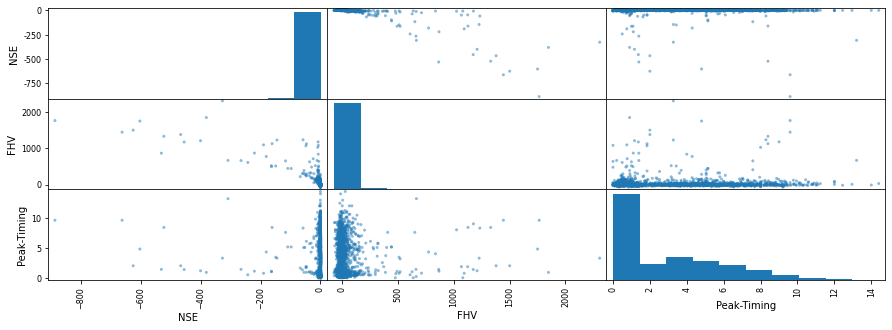

In [27]:
# results_df_m
scatter_matrix(results_df_m[['NSE', 'FHV', 'Peak-Timing']], figsize=(15, 5), diagonal='hist'); # diagonal='kde'


#### show table to compare metrics and signatures (median per model)

(useful to comare models over US catchments)

In [29]:
drop_cols = ['Alpha-NSE', 'Beta-NSE', 'MSE', 'RMSE', 'Pearson-r', 'FMS', 'FLV']
# metrics

# group by model
medians_m = results_df_m.groupby(['model', 'freq']).median()
medians_m['NSE_mean'] = results_df_m['NSE'].groupby(['model', 'freq']).mean()
medians_m['NSE<0'] = results_df_m['NSE'].groupby(['model', 'freq']).apply(lambda x: (x<0).sum())
medians_m['KGE<-0.41'] = results_df_m[['KGE']].groupby(['model', 'freq']).apply(lambda x: (x<-0.41).sum())
medians_m.drop(columns=drop_cols, inplace=True)

# group by HUC
medians_huc_m = results_df_m.groupby(['huc_02', 'model', 'freq']).median()
medians_huc_m['NSE_mean'] = results_df_m[['NSE', 'huc_02']].groupby(['huc_02', 'model', 'freq']).mean()
medians_huc_m['NSE<0'] = results_df_m[['NSE', 'huc_02']].groupby(['huc_02', 'model', 'freq']).apply(lambda x: (x<0).sum())
medians_huc_m['KGE<-0.41'] = results_df_m[['KGE', 'huc_02']].groupby(['huc_02', 'model', 'freq']).apply(lambda x: (x<-0.41).sum())
medians_huc_m.drop(columns=drop_cols, inplace=True)


# group by cluster
medians_cluster_m = results_df_m.groupby(['Cluster', 'model', 'freq']).median()
medians_cluster_m['NSE_mean'] = results_df_m[['NSE', 'Cluster']].groupby(['Cluster', 'model', 'freq']).mean()
# medians_cluster_m['NSE<0'] = results_df_m[['NSE', 'Cluster']].groupby(['Cluster', 'model', 'freq']).apply(lambda x: (x<0).sum())
# medians_cluster_m['KGE<-0.41'] = results_df_m[['KGE', 'Cluster']].groupby(['Cluster', 'model', 'freq']).apply(lambda x: (x<-0.41).sum())
medians_cluster_m.drop(columns=drop_cols, inplace=True)


print('Median metrics per model over all US catchments:')
display(medians_m.style.format('{:.2f}'))

print('Median metrics per model and HUC:')
display(medians_huc_m.style.format('{:.2f}'))

print('Median metrics per model and HUC:')
display(medians_cluster_m.style.format('{:.2f}'))


Median metrics per model over all US catchments:


Median metrics per model and HUC:


Median metrics per model and HUC:


In [31]:
metrics_dict = {'Model_median': medians_m,
               'per_HUC': medians_huc_m,
               'per_cluster': medians_cluster_m}

In [32]:
with open('data/results/new_loss_US/metrics_tables.p', 'wb') as f:
    pickle.dump(metrics_dict, f, protocol=pickle.DEFAULT_PROTOCOL)

In [34]:
keep_cols = ['high_q_freq', 'high_q_dur', 'q95', 'hfd_mean', 'runoff_ratio']
# signatures

# group by model and freq
medians_s = results_df_s_huc.groupby(['model', 'freq']).median()
medians_huc_s = results_df_s_huc.groupby(['huc_02', 'model', 'freq']).median()

# group by huc
medians_huc_s = results_df_s_huc.groupby(['huc_02', 'model', 'freq']).median()
medians_huc_s = medians_huc_s[keep_cols]

# hfd mean from hours to days
medians_s.loc[pd.IndexSlice[:, '1H'], 'hfd_mean'] = medians_s.loc[pd.IndexSlice[:, '1H'], 'hfd_mean'] / 24
medians_huc_s.loc[pd.IndexSlice[:, :, '1H'], 'hfd_mean'] = medians_huc_s.loc[pd.IndexSlice[:, :, '1H'], 'hfd_mean'] / 24

print('Median signatures per model over all US catchments:')
display(medians_s.style.format('{:.3f}'))

print('Median signatures per model and HUC:')
display(medians_huc_s.style.format('{:.3f}'))


Median signatures per model over all US catchments:


Median signatures per model and HUC:


In [35]:
# signatures
# determine correlation of signatures based on simulated streamflow and based on observed streamflow

# ADD HUC



# SHOULD BE COMPARED TO HYDROMT SIGNATURES!!!



signature_corr = pd.DataFrame(index=frequencies, columns=results_df_s.columns, dtype=float)
signature_corr.index.rename('freq', inplace=True)
signature_corr = pd.concat({models[-1]: signature_corr}, names=['model'])
signature_corr.loc[(models[0], frequencies[0]),:] = np.full([1, len(signature_corr.columns)], np.nan).tolist()[0]
signature_corr.loc[(models[0], frequencies[1]),:] = np.full([1, len(signature_corr.columns)], np.nan).tolist()[0]

for freq in frequencies:
    for model in models:
        for sig in signature_corr.columns:
            name_obs = 'obs_'+model
            sig_obs = results_df_s.loc(axis=0)[name_obs, freq][sig].sort_index()
            sig_sim = results_df_s.loc(axis=0)[model, freq][sig].reindex(sig_obs.index)
            mask = ~(pd.isna(sig_obs) | pd.isna(sig_sim))
            if mask.sum() ==0:
                continure
            signature_corr.loc(axis=0)[model, freq][sig] = pearsonr(sig_obs[mask].values, sig_sim[mask].values)[0]

signature_corr = signature_corr[keep_cols]
            
display(signature_corr.style.format('{:.3f}')) # reindex(sorted(signature_corr.index, key=lambda x: x.lower()))

C:\Users\wilbrand\Miniconda3\envs\myenv\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
